In [197]:
from sklearn import datasets

iris = datasets.load_iris()

In [198]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
import numpy as np
from sklearn.model_selection import GridSearchCV

In [199]:
import matplotlib.pyplot as plt

In [200]:
X = iris.data[:, 2:4]  # we only take the first two features.
#y = [1] * 50 + [0] * 100
y = [0] * 50 + [1] * 50 + [0] * 50

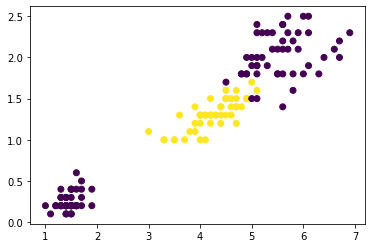

In [201]:
plt.scatter(X[:,0],X[:,1], c=y)
plt.show()

In [202]:
X_scaled = MaxAbsScaler().fit_transform(iris.data)
X_reduced = PCA(n_components=2).fit_transform(X_scaled)
X_class, y_class = np.concatenate((X_reduced[:50], X_reduced[100:])), np.concatenate((y[:50], y[100:]))

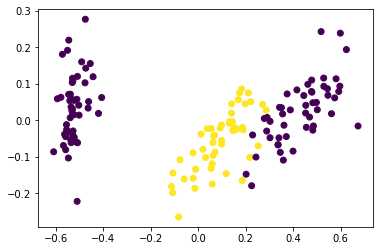

In [203]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y)
plt.show()

In [204]:
import sys

sys.path.append('..')

from flod.classifiers.bsvclassifier import BSVClassifier

In [205]:
max_dist = 0
for i in X:
    for j in X:
        dist = np.linalg.norm(i-j, ord=2)**2
        if dist > max_dist:
            max_dist = dist

print(f'Suggested q: {1/max_dist}')

Suggested q: 0.025497195308516064


In [206]:
q = 10
p = 50

c = 1

print(f'p={1 / (c*len(X_reduced))}')

p=0.006666666666666667


In [207]:
clf = BSVClassifier(n_iter=10, c=c, q=q, penalization=200)
clf.fit(X_class, y_class)

BSVClassifier(c=1, init_bound=0.1, n_iter=10, penalization=200, q=10,
              random_seed=42)

In [208]:
y_pred = clf.predict(X_reduced)

In [209]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'Precision {precision_score(y, y_pred)}')
print(f'Recall {recall_score(y, y_pred)}')
print(f'F1 {f1_score(y, y_pred)}')
print(f'Accuracy {accuracy_score(y, y_pred)}')

Precision 1.0
Recall 0.46
F1 0.6301369863013699
Accuracy 0.82


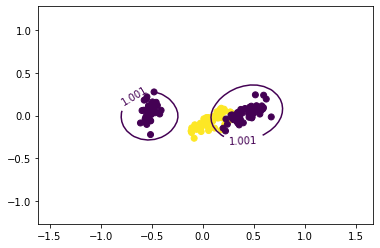

In [210]:
gx = np.linspace(min(X_reduced[:,0])-1, max(X_reduced[:,0])+1, 50)
gy = np.linspace(min(X_reduced[:,1])-1, max(X_reduced[:,1])+1, 50)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radiuses_[clf.sv_i], ))
plt.clabel(membership_contour, inline=1)

plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y)
plt.show()

In [211]:
from joblib import dump, load
dump(clf, 'iris.joblib') 

['iris.joblib']

**Analizzare risultato di questa run in altro notebook**

In [212]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
        ('scaler', MaxAbsScaler()),
        ('reduce_dim', PCA()),
        ('classifier', BSVClassifier())
])

In [227]:
params = {
    'scaler': [StandardScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer()],
    'reduce_dim__n_components': [2,3],
    'classifier__c': [1],
    'classifier__n_iter': [10],
    'classifier__penalization': [200],
    'classifier__q': [1, 5, 10, 15, 20]
}

search = GridSearchCV(pipe, params, n_jobs=-1)

In [228]:
search.fit(X_class, y_class)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler', MaxAbsScaler(copy=True)),
                                       ('reduce_dim',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('classifier',
                                        BSVClassifier(c=0.25, init_bound=0.1,
                                                      n_iter=100,
                                                      penalization=10, q=1,
                                                      random_seed=42))],
                                verbose=False)...
                                                   wi

In [229]:
print(f'Best params: {search.best_params_}')
print(f'Best score: {search.best_score_}')

Best params: {'classifier__c': 1, 'classifier__n_iter': 10, 'classifier__penalization': 200, 'classifier__q': 1, 'reduce_dim__n_components': 2, 'scaler': MaxAbsScaler(copy=True)}
Best score: 1.0


1. Come posso far si che q vari in base ai risultati? Sarebbe figo fare binary search
1. Come posso fare una cross validation che traini solo con un subset di y = 0 e faccia evaluation con gli zeri rimanenti e 1?